# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ../python
from unityagents import UnityEnvironment
import numpy as np
import sys
from matplotlib import pyplot as plt
from pathlib import Path
import torch

sys.path.append("./src")

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2
from agent import DDPG_Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# Initiate the resource paths
resource_path = Path("resources")

weight_path = resource_path.joinpath("weights")
plot_path = resource_path.joinpath("plots")
metric_path = resource_path.joinpath("metrics")

weight_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)
metric_path.mkdir(parents=True, exist_ok=True)

In [4]:
env = UnityEnvironment(file_name=r"Reacher_Linux_NoVis_single/Reacher.x86_64", worker_id=8089)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Training the agent

Make sure to train reset the enviornment for each episode, do this in the following maner.
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
agent = DDPG_Agent(state_size=state_size, action_size=action_size, seed=0, use_noise=True)
print(agent.local_actor)
print(agent.local_critic)

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0      

Actor(
  (fcs): Sequential(
    (0): Linear(in_features=33, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=4, bias=True)
  )
)
Critic(
  (fc_embedd): Sequential(
    (0): Linear(in_features=33, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc_action_map): Sequential(
    (0): Linear(in_features=404, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)


Episode 20	 Mean score: 1.45	Average Score: 0.57
Episode 30	 Mean score: 2.50	Average Score: 0.72
Episode 40	 Mean score: 0.42	Average Score: 0.85
Episode 50	 Mean score: 0.81	Average Score: 0.90
Episode 60	 Mean score: 1.64	Average Score: 0.95
Episode 70	 Mean score: 2.34	Average Score: 1.09
Episode 80	 Mean score: 2.74	Average Score: 1.31
Episode 90	 Mean score: 1.06	Average Score: 1.41
Episode 100	 Mean score: 3.00	Average Score: 1.52
Episode 110	 Mean score: 1.51	Average Score: 1.78
Episode 120	 Mean score: 3.04	Average Score: 1.99
Episode 130	 Mean score: 6.64	Average Score: 2.30
Episode 140	 Mean score: 2.29	Average Score: 2.60
Episode 150	 Mean score: 4.75	Average Score: 3.04
Episode 160	 Mean score: 5.31	Average Score: 3.36
Episode 170	 Mean score: 3.89	Average Score: 3.70
Episode 180	 Mean score: 9.39	Average Score: 4.21
Episode 190	 Mean score: 7.97	Average Score: 4.86
Episode 200	 Mean score: 5.84	Average Score: 5.32
Episode 210	 Mean score: 8.40	Average Score: 5.98
Episode 

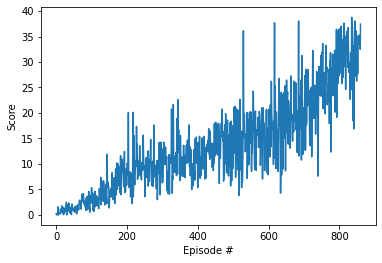

In [8]:
from collections import deque

score_goal = 30
score_window = 100

def ddpg(n_episodes=1000, max_t=1000, score_window=100, print_freq=10): #, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        score_window (int) : 

    """
    scores = []                                 # list containing scores from each episode
    scores_window = deque(maxlen=score_window)  # last 100 scores
    # eps = eps_start                             # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = 0
        agent.reset_noise()
        
        for t in range(max_t):

            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)

            states = next_states
            score += reward
            if np.any(dones):
                break 
        scores_window.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))              # save most recent score

        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % print_freq == 0:
            print('\rEpisode {}\t Mean score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score), np.mean(scores_window)))
        if np.mean(scores_window)>=score_goal:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            np.save(str(metric_path.joinpath("single_continous_goal.npy")), np.array(i_episode))
            torch.save(agent.local_actor.state_dict(), str(weight_path.joinpath('single_control_actor.pth')))
            torch.save(agent.local_critic.state_dict(), str(weight_path.joinpath('single_control_critic.pth')))
            break
    return scores

scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)

#
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

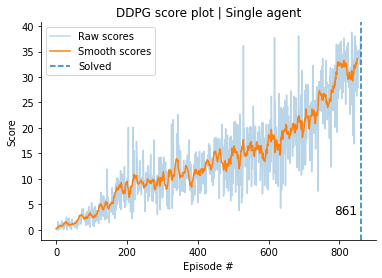

In [17]:
env_solved = np.load(metric_path.joinpath("single_continous_goal.npy"))
np.save(str(metric_path.joinpath("single_control_score.npy")), np.array(scores))


mean_scores = moving_average(scores, 10)
fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores, alpha=0.3, label="Raw scores")
ax.plot(np.arange(len(mean_scores)), mean_scores, label="Smooth scores")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axvline(env_solved, 0.0, 1, color="#1f77b4", linestyle='--', label="Solved")
plt.text(env_solved-75, 3,str(env_solved), fontsize=12)

plt.legend(loc="upper left")
plt.title("DDPG score plot | Single agent")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig(str(plot_path.joinpath("single_control_plot.png")))

When finished, you can close the environment.

In [11]:
env.close()